# TODO: 
- check learning rates
- check early stopping
- check callbacks
- check corect loss functions
- train last layer
- make vgg16

Run the follwing cell to pip install the necerssary packages specified in the requirements.txt file.

In [6]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 22.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.2/392.2 kB 10.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 28.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 42.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 MB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12

In [2]:
import os
import io
import tensorflow as tf
import numpy as np
from azure.storage.blob import BlobServiceClient, ContainerClient
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pandas as pd

from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import MobileNetV2


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix


#from tensorflow.keras.layers import Dense, Flatten
#from tensorflow.keras.models import Model, Sequential
#from keras.layers import MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, Flatten
#from keras.models import Model

#from keras.layers import MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, Flatten
#from keras.models import Model
#from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.callbacks import EarlyStopping




2024-05-12 19:43:41.503201: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 19:43:41.507770: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-12 19:43:41.587558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 19:43:42.937754: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Connect to Azure

In [3]:
#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "meterml"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

### Load Image Paths and Labels

In [11]:
#get filepaths
df = pd.read_csv("FINAL_METER_ML_test.csv")


# convert each string in the DataFrame to a list
df['Label'] = df['Label'].apply(ast.literal_eval)

# convert each list in the DataFrame to a numpy array
df['Label'] = df['Label'].apply(np.array)


#create dictionary with labels and encoded labels
#unique_types = df['Type'].unique()
#unique_type_encoded = df['Label'].unique()
#type_dict = {}
#for i in range(len(unique_types)):
#    type_dict[unique_type_encoded[i]] = unique_types[i]
#sorted_type_dict = dict(sorted(type_dict.items()))
#sorted_type_dict

class_names=["CAFOs","Landfills","Mines","Negative","ProcessingPlants","RefineriesAndTerminals","WWTreatment"]

### Functions 
- create data (input for models)
- plot accuracy and loss of models
- metrices
- print dataset
- print evaluation metrices

In [41]:
image_size=224
channels=3
autotune = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically

def data_split(df):
    """Splits and returns the dataset into training, validation, and test"""
    X_temp, X_test, y_temp, y_test = train_test_split(df['Image_Folder'], df['Label'], test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)
    #convert labels to array
    y_train = np.array(y_train).tolist()
    y_val = np.array(y_val).tolist()
    y_test = np.array(y_test).tolist()
    #print number of observations per datasets
    print("Nr. Training:",len(X_train),"Nr. Validation:",len(X_val),"Nr. Test:",len(X_test))
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def load_image(path):
    """Load an image from Azure Blob Storage."""
    blob_client = container_client.get_blob_client(path)
    blob_data = blob_client.download_blob().readall()  # Directly read all bytes
    
    return io.BytesIO(blob_data)


def load_and_preprocess_image(path):
    """Loads an image, decodes it to grayscale, resizes, and normalizes it."""
    # Load image
    image_file = load_image(path.numpy().decode('utf-8'))
    # Decode the image to grayscale
    image_tensor = tf.io.decode_image(image_file.getvalue(), channels=channels)
    # Resize the image
    image_resized = tf.image.resize(image_tensor, [image_size, image_size])
    # Normalize the image data
    image_normalized = image_resized / 255.0
    return image_normalized


def process_tensor(path, label):
    """Function to load an image from blob storage, decode, resize, and normalize it."""
    image_normalized = tf.py_function(load_and_preprocess_image, [path], tf.float32)
    # Ensure the shape is set correctly for grayscale
    image_normalized.set_shape([image_size, image_size, channels])
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Creates a TensorFlow dataset from filenames and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(process_tensor, num_parallel_calls=tf.data.AUTOTUNE)
    #shuffle the data when it is the training dataset
    if is_training:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=1024)
    #creates batches    
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


def create_all_datasets(X_train, X_val, X_test, y_train, y_val, y_test ):
    """Creates train, test, and val datasets by calling the create_dataset function each."""
    train_ds = create_dataset(X_train, y_train)
    test_ds = create_dataset(X_test, y_test, False)
    val_ds = create_dataset(X_val, y_val, False)
    
    return train_ds, test_ds, val_ds


def print_dataset(dataset):
    """Print the plain dataset."""
    for images, labels in dataset.take(1):  # Here, take(1) takes the first batch
        print("Images:", images.numpy())  # Convert tensor to numpy array and print
        print("Labels:", labels.numpy())  # Convert tensor to numpy array and print


def plot_history(model):
    """Plots the accuracy and loss of the inputted model."""
    # summarize history for accuracy
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


def print_predictions(model, ds):
    """Predictions based on test dataset."""
    #predict
    for images, labels in ds:
        predictions = model.predict(images)  # Only pass image data
        classes = predictions.argmax(axis=-1) #selects biggest value as prediction

        for pred, classe, label in zip(predictions,classes, labels):
            print("Prediction:", pred,"Pred. Class: ",classe, "Actual Label:", label.numpy())# Print the first prediction
        break
    
        
def plot_model(model): 
    """Plot model with predefined arguments."""
    plot_model(model, 
            to_file='vgg.png',
            show_shapes=True,
            show_dtype=True,
            show_layer_names=True,
            show_layer_activations=True,
            show_trainable=False)
    

def evaluate_model(model, test_ds):
    result = model.evaluate(test_ds)
    # Assuming accuracy was the second metric (index 1), extract the accuracy.
    test_accuracy = result[1] * 100  # Convert to percentage
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy


def true_pred_classes(model, dataset): 
    """
    Evaluates the given model using the dataset.
    Returns: accuracy, f1, recall, precision, confusion matrix
    """
    # Collect all labels and predictions
    true_classes = []
    predicted_classes = []

    # Iterate over the dataset
    for images, labels in dataset:
        # Predict batch
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        true = labels.numpy()  # Assuming labels are already integer-encoded

        # Append to lists
        true_classes.extend(true)
        predicted_classes.extend(preds)
    return true_classes,predicted_classes


def print_conf_matrix(true_classes, predicted_classes, class_names):
    """
    Print confusion matrix.
    """
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    df_cm = pd.DataFrame(
        conf_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=(10,7))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')

    # Set aesthetics for better readability
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


### How to call different plots and metrices:
- plot_history(history)
- print_predictions(inceptionv3_model, test_ds)
- true_classes,predicted_classes = true_pred_classes(inceptionv3_model, test_ds)
- accuracy_score(true_classes,predicted_classes)
- f1_score(true_classes, predicted_classes, average='weighted')
- recall = recall_score(true_classes, predicted_classes, average='weighted')
- precision = precision_score(true_classes, predicted_classes, average='weighted')
- conf_matrix = confusion_matrix(true_classes, predicted_classes)
- print_conf_matrix(true_classes, predicted_classes,class_names)

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = data_split(df)
    
train_ds, test_ds, val_ds = create_all_datasets(X_train, X_val, X_test, y_train, y_val, y_test)

Nr. Training: 692 Nr. Validation: 149 Nr. Test: 149


### MobileNetV2: 
https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb

Epoch 1/10


2024-05-12 19:49:04.769901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 90 of 1024
2024-05-12 19:49:23.636484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 385 of 1024
2024-05-12 19:49:41.858818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.3157 - loss: 3.0637 - val_accuracy: 0.2349 - val_loss: 2.8290
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.3697 - loss: 1.9967 - val_accuracy: 0.5101 - val_loss: 1.4828
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5291 - loss: 1.3944 - val_accuracy: 0.4631 - val_loss: 1.6895
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5620 - loss: 1.2707 - val_accuracy: 0.4899 - val_loss: 1.3254
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.6496 - loss: 0.9568 - val_accuracy: 0.4698 - val_loss: 1.4151
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.6702 - loss: 0.8741 - val_accuracy: 0.4966 - val_loss: 1.3211
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.7104 - loss: 0.7469 - val_accuracy: 0.5101 - val_loss: 1.2494
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.7774 - loss: 0.6541 - val_accuracy: 0.5436 - val_loss: 1.2667
Epoch 9/10
3/3 ━━━━━━━━━━━

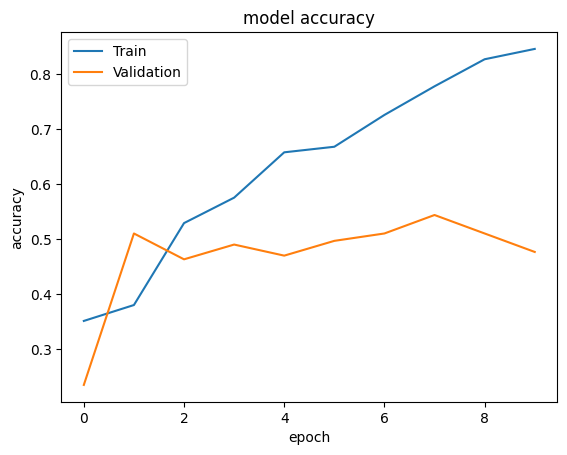

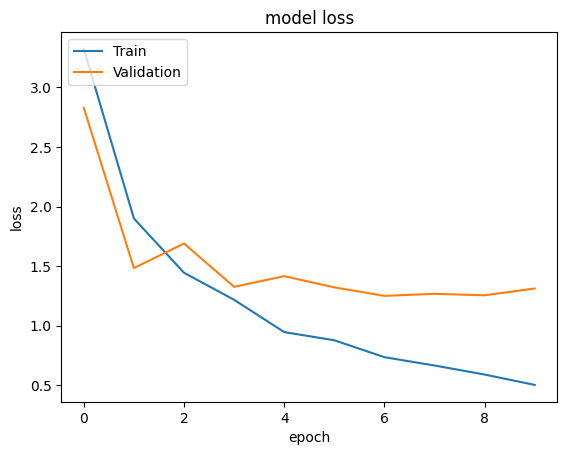

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step


AttributeError: 'Functional' object has no attribute 'pred_classes'

In [14]:

# Load MobileNetV2 from Keras Applications
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout for regularization
predictions = Dense(7, activation='softmax')(x)  # Final layer with softmax activation for classification

# Construct the full model
model_mnv2 = Model(inputs=base_model.input, outputs=predictions)
model_mnv2.compile(optimizer="adam",
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    

# Assuming train_ds, X_test, y_test are properly defined
history = model_mnv2.fit(train_ds,
                      validation_data = val_ds, 
                      epochs=10)

plot_history(history)
print_predictions(model_mnv2, test_ds)

### Inception.v3: 
https://towardsdatascience.com/understanding-the-amazon-rainforest-with-multi-label-classification-vgg-19-inceptionv3-5084544fb655

In [ ]:
#create inception v3
inceptionv3 = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in inceptionv3.layers:
    layer.trainable = False

# Adding custom layers
x = inceptionv3.output
x = GlobalAveragePooling2D()(x)  # Ensure this reduces all spatial dimensions
x = Dense(4096, activation="relu")(x)
x = Dropout(0.1)(x)
output = Dense(7, activation="softmax")(x)  # Adjust the number of output units to match the number of classes

# Creating the final model
inceptionv3_model = Model(inputs=inceptionv3.input, outputs=output)
inceptionv3_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Set up the model checkpoint
model_checkpoint = ModelCheckpoint('inceptionv3_model.keras', monitor="val_accuracy", verbose=1, save_best_only=True)

# Assuming train_ds, X_test, y_test are properly defined
history = inceptionv3_model.fit(train_ds,
                      validation_data = val_ds, 
                      epochs=10, 
                      callbacks=[model_checkpoint])

plot_history(history)

In [15]:
type(model_mnv2)

keras.src.models.functional.Functional

### VGG16 with transfer learning: 
- https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4
- https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb#scrollTo=9Qm1-H5F0KEV

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(7, activation='softmax')

vgg16_tf_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

vgg16_tf_model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=5,  
                   restore_best_weights=True)

history = vgg16_tf_model.fit(train_ds, 
                        validation_data = val_ds, 
                        epochs=10, 
                        batch_size=32, 
                        callbacks=[es])

plot_history(history)
print_predictions(vgg16_tf_model, test_ds)

### ResNet50: 
- https://datagen.tech/guides/computer-vision/resnet-50/
- https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
- https://medium.com/@ozgunhaznedar/image-classification-on-satellite-images-with-deep-learning-baa9813dde4e

In [ ]:
resnet_model = Sequential()

rn50_base = tf.keras.applications.ResNet50(
    weights = "imagenet",
    input_shape=(224,224,3)
    )

for each_layer in rn50_base.layers:

        each_layer.trainable=False

resnet_model.add(rn50_base)

resnet_model.add(Flatten())

resnet_model.add(Dense(512, activation='relu'))

resnet_model.add(Dense(7, activation='softmax'))

resnet_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data = val_ds, epochs=10)

plot_history(resnet_model)
print_predictions(resnet_model, test_ds)

### Self-trained VGG16
Source: https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f

In [ ]:
_input = Input((224,224,1)) 

conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(conv1)
pool1  = MaxPooling2D((2, 2))(conv2)

conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(conv3)
pool2  = MaxPooling2D((2, 2))(conv4)

conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv5)
conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(conv6)
pool3  = MaxPooling2D((2, 2))(conv7)

conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv8)
conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv9)
pool4  = MaxPooling2D((2, 2))(conv10)

conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv11)
conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(conv12)
pool5  = MaxPooling2D((2, 2))(conv13)

flat   = Flatten()(pool5)
dense1 = Dense(4096, activation="relu")(flat)
dense2 = Dense(4096, activation="relu")(dense1)
output = Dense(7, activation="softmax")(dense2) #adapted number of outputs and outputfunction

vgg16_model  = Model(inputs=_input, outputs=output)

LR = 1e-5 #why?

#compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

##provide a model summary
vgg16_model.summary()

#fit the model
vgg16_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10
)

plot_history(vgg16_model)
print_predictions(vgg16_model, test_ds)